In [1]:
%%capture
## compile PyRoss for this notebook
import os
owd = os.getcwd()
os.chdir('../../')
%run setup.py install
os.chdir(owd)

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pyross

## Introduction

In this notebook, we consider an SIR model with a lockdown protocol that is put in place once the infective population exceeds a threshold, and is removed after a fixed time

## Define system parameters

In [3]:
# Define basic system parameters

M = 1                  # the SIR model has no age structure
Ni = 50000*np.ones(M)   # so there is only one age group 
N = np.sum(Ni)         # and the total population is the size of this age group

beta  = 0.2          # infection rate
gamma = 0.1         # removal rate 
alpha = 0.0            # fraction of asymptomatic infectives 
fsa   = 1              # the self-isolation parameter 

Ia0 = np.array([0])     # the SIR model has only one kind of infective 
Is0 = np.array([20])    # we take these to be symptomatic 
R0  = np.array([0])     # and assume there are no recovered individuals initially 
S0  = N-(Ia0+Is0+R0)    # so that the initial susceptibles are obtained from S + Ia + Is + R = N

parameters = {'alpha':alpha, 'beta':beta,'fsa':fsa,
             'gIa':gamma,'gIs':gamma}

model = pyross.control.SIR(parameters, M, Ni)

## Define events at which contact matrix is modified

For every change in the contact matrix that could occur, we have to define an *event*. An event is a function of time and the current state, and the event happens once the function becomes zero (from a given side).

The program expects 
* a list of events, and 
* a list containing either constant contact matrices and/or constant matrix functions.

If event $i$ takes place, then the $i$-th contact matrix/contact matrix function from the list is used in the simulation.

The simulation always starts with the first contact matrix from the list, and the corresponding event can only occur once another event has occured (below we will use a dummy event that can never occur).

The time-dependence of a contact matrix function is always relative to the time of the event that triggered it. This means that at time $t$, a contact matrix function is always evaluated at $t-t_{e}$, where $t_{e}$ is the event at that triggered the contact matrix function.

We now define three events:

In [4]:
events = []
contactMatrices = []

# Note that for technical reasons, the event functions take a
# vector argument "rp" instead of a tuple (S,Ia,Is).
# When defining the event functions, the following correspondence has to be used:
# S  == xt[ :M]
# Ia == xt[M:2*M]
# Is == xt[2*M: ]

# This is a dummy event which will never occur; it is used to set the initial contact matrix
def cur_event(t,xt):
    return t + 1
cur_event.direction = +1
events.append(cur_event)
contactMatrices.append( np.identity(M) )

# Lockdown (= multiply beta by a factor 1/2) once number of infectives I_s becomes larger than 2000
def cur_event2(t,xt):
    return xt[2] - 1000
cur_event2.direction = +1 # this means we need to pass the threshold from below for the event to happen
events.append(cur_event2)
# upon the event, the contact matrix fades out exponentially (over t_lockdown_fadeout days)
# to 0.3 times its original value. 
# After lockdown_length days, the original contact matrix is restored.
t_lockdown_fadeout = 20
lockdown_length=100.
def contactMatrix2(t):
    if t < lockdown_length:
        return np.identity(M)*(0.7*np.exp(-t/t_lockdown_fadeout)+0.3)
    else:
        return np.identity(M)
contactMatrices.append( contactMatrix2 )

## Simulate system and plot result

In [5]:
# Run simulation
Tf = 500
Nt = (Tf +1)*10

result = model.simulate(S0, Ia0, Is0 ,events=events,
                        contactMatrices=contactMatrices,Tf=Tf, Nf=Nt,
                        method='gillespie',
                        #stop_at_event=True,
                       )

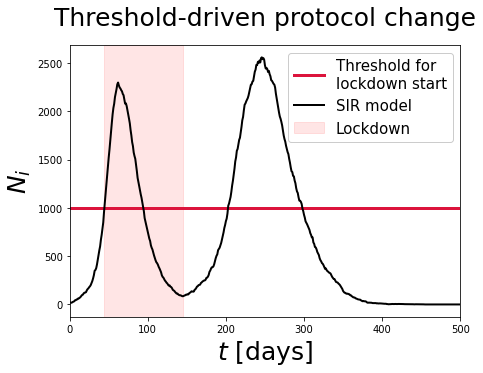

In [6]:
# Plot result
t_arr = result['t']
trajs = result['X'].T

fontsize=25
fig, ax = plt.subplots(1,1,figsize=(7,5))
ax.set_title('Threshold-driven protocol change',
            y=1.05,fontsize=25)
ax.axhline(1000,color='crimson',
           lw=3,
           label='Threshold for\nlockdown start')
for i,e in enumerate(result['events_occured']):
    if e[1] == 1:
        ax.axvspan(e[0],e[0]+lockdown_length, 
            label='Lockdown',
           alpha=0.1, color='red')
        
for i,traj in enumerate(trajs):
    if i != 2:
        continue
    ax.plot(t_arr,traj,
            label='SIR model', 
            color='black',
            lw=2,
           )
ax.set_xlim(np.min(t_arr),np.max(t_arr))
ax.set_ylabel(r'$N_i$',fontsize=fontsize)
ax.set_xlabel(r'$t$ [days]',fontsize=fontsize)
ax.legend(loc='best',
          framealpha=1,
         fontsize=15)
plt.show()
plt.close()